In [10]:
filename = "RAD60_OPER_O___TARVOL__L2__20120722T000000_20120723T000000_0001/RAD_NL60_VOL_NA_201207220035.h5"

In [29]:
from osgeo import osr

def polar2lonlatalt_n(r, az, elev, sitecoords, re=None, ke=4. / 3.):
    """Transforms polar coordinates (of a PPI) to longitude/latitude \
    coordinates taking elevation angle and refractivity into account.

    It takes the shortening of the great circle
    distance with increasing  elevation angle as well as the resulting
    increase in height into account.

    Parameters
    ----------
    r : :class:`numpy:numpy.ndarray`
        Array of ranges [m]
    az : :class:`numpy:numpy.ndarray`
        Array of azimuth angles containing values between 0 and 360°.
        These are assumed to start with 0° pointing north and counted
        positive clockwise!
    elev : scalar or :class:`numpy:numpy.ndarray` of the same shape as az
        Elevation angles in degrees starting with 0° at horizontal to 90°
        pointing vertically upwards from the radar
    sitecoords : a sequence of two or three floats
        The lon / lat coordinates of the radar location, the third value,
        if present, will be interpreted as the height of the site above the
        geoid (i.e. sphere)
    re : float
        Earth's radius [m], if None, `get_earth_radius` will be used to
        determine the equivalent radius of the WGS84 ellipsoid for the
        latitude given in sitecoords.
    ke : float
        Adjustment factor to account for the refractivity gradient that
        affects radar beam propagation. In principle this is wavelength-
        dependent. The default of 4/3 is a good approximation for most
        weather radar wavelengths

    Returns
    -------
    lon, lat, alt : tuple of :class:`numpy:numpy.ndarray`
        Three arrays containing the spherical longitude and latitude
        coordinates as well as the altitude of the beam.

    Note
    ----
    The function uses osgeo/gdal functionality to reproject from azimuthal
    equidistant projection to spherical geographical coordinates.
    The earth model for this conversion is therefore spherical.
    This should not introduce too much error for common radar coverages, but
    you should be aware of this, when trying to do high resolution spatial
    analyses.

    Examples
    --------

    A few standard directions (North, South, North, East, South, West) with
    different distances (amounting to roughly 1°) from a site
    located at 48°N 9°E

    >>> r  = np.array([0.,   0., 111., 111., 111., 111.,])*1000
    >>> az = np.array([0., 180.,   0.,  90., 180., 270.,])
    >>> th = np.array([0.,   0.,   0.,   0.,   0.,  0.5,])
    >>> csite = (9.0, 48.0)
    >>> lon1, lat1, alt1 = polar2lonlatalt_n(r, az, th, csite)
    >>> for x, y, z in zip(lon1, lat1, alt1):
    ...     print( '{0:7.4f}, {1:7.4f}, {2:7.4f}'.format(x, y, z))
    ...
     9.0000, 48.0000,  0.0000
     9.0000, 48.0000,  0.0000
     9.0000, 48.9981, 725.7160
    10.4872, 47.9904, 725.7160
     9.0000, 47.0017, 725.7160
     7.5131, 47.9904, 1694.2234

    Here, the coordinates of the east and west directions won't come to lie on
    the latitude of the site because the beam doesn't travel along the latitude
    circle but along a great circle.

    See :ref:`notebooks/basics/wradlib_workflow.ipynb#\
Georeferencing-and-Projection`.

    """
    r = np.asarray(r)
    az = np.asarray(az)
    elev = np.asarray(elev)

    # use wgs84 ellipsoid
    sph = get_default_projection()

    # coords is calculated via the formulas of Doviak
    coords = spherical_to_proj(r, az, elev, sitecoords, sph, re=re, ke=ke)

    return coords[..., 0], coords[..., 1], coords[..., 2]


def get_default_projection():
    """Create a default projection object (wgs84)"""
    proj = osr.SpatialReference()
    proj.ImportFromEPSG(4326)
    return proj

def spherical_to_proj(r, phi, theta, sitecoords, proj=None, re=None, ke=4./3.):
    """Transforms spherical coordinates (r, phi, theta) to projected
    coordinates centered at sitecoords in given projection.

    It takes the shortening of the great circle
    distance with increasing elevation angle as well as the resulting
    increase in height into account.

    .. versionadded:: 0.11.2

    Parameters
    ----------
    r : :class:`numpy:numpy.ndarray`
        Contains the radial distances.
    phi : :class:`numpy:numpy.ndarray`
        Contains the azimuthal angles.
    theta: :class:`numpy:numpy.ndarray`
        Contains the elevation angles.
    sitecoords : a sequence of three floats
        the lon / lat coordinates of the radar location and its altitude
        a.m.s.l. (in meters)
        if sitecoords is of length two, altitude is assumed to be zero
    proj : osr object
        Destination Spatial Reference System (Projection).
        Defaults to wgs84 (epsg 4326).
    re : float
        earth's radius [m]
    ke : float
        adjustment factor to account for the refractivity gradient that
        affects radar beam propagation. In principle this is wavelength-
        dependent. The default of 4/3 is a good approximation for most
        weather radar wavelengths.

    Returns
    -------
    coords : :class:`numpy:numpy.ndarray`
        Array of shape (..., 3). Contains projected map coordinates.

    Examples
    --------

    A few standard directions (North, South, North, East, South, West) with
    different distances (amounting to roughly 1°) from a site
    located at 48°N 9°E

    >>> r  = np.array([0.,   0., 111., 111., 111., 111.,])*1000
    >>> az = np.array([0., 180.,   0.,  90., 180., 270.,])
    >>> th = np.array([0.,   0.,   0.,   0.,   0.,  0.5,])
    >>> csite = (9.0, 48.0)
    >>> coords = spherical_to_proj(r, az, th, csite)
    >>> for coord in coords:
    ...     print( '{0:7.4f}, {1:7.4f}, {2:7.4f}'.format(*coord))
    ...
     9.0000, 48.0000,  0.0000
     9.0000, 48.0000,  0.0000
     9.0000, 48.9981, 725.7160
    10.4872, 47.9904, 725.7160
     9.0000, 47.0017, 725.7160
     7.5131, 47.9904, 1694.2234

    Here, the coordinates of the east and west directions won't come to lie on
    the latitude of the site because the beam doesn't travel along the latitude
    circle but along a great circle.

    See :ref:`notebooks/basics/wradlib_workflow.ipynb#\
Georeferencing-and-Projection`.

    """
    if proj is None:
        proj = get_default_projection()

    xyz, rad = spherical_to_xyz(r, phi, theta, sitecoords, re=re, ke=ke)

    # reproject aeqd to destination projection
    coords = reproject(xyz, projection_source=rad, projection_target=proj)

    return coords


def spherical_to_xyz(r, phi, theta, sitecoords, re=None, ke=4./3.):
    """Transforms spherical coordinates (r, phi, theta) to cartesian
    coordinates (x, y, z) centered at sitecoords (aeqd).

    It takes the shortening of the great circle
    distance with increasing elevation angle as well as the resulting
    increase in height into account.

    .. versionadded:: 0.11.2

    Parameters
    ----------
    r : :class:`numpy:numpy.ndarray`
        Contains the radial distances in meters.
    phi : :class:`numpy:numpy.ndarray`
        Contains the azimuthal angles in degree.
    theta: :class:`numpy:numpy.ndarray`
        Contains the elevation angles in degree.
    sitecoords : a sequence of three floats
        the lon / lat coordinates of the radar location and its altitude
        a.m.s.l. (in meters)
        if sitecoords is of length two, altitude is assumed to be zero
    re : float
        earth's radius [m]
    ke : float
        adjustment factor to account for the refractivity gradient that
        affects radar beam propagation. In principle this is wavelength-
        dependent. The default of 4/3 is a good approximation for most
        weather radar wavelengths.

    Returns
    -------
    xyz : :class:`numpy:numpy.ndarray`
        Array of shape (..., 3). Contains cartesian coordinates.
    rad : osr object
        Destination Spatial Reference System (Projection).
        Defaults to wgs84 (epsg 4326).
    """
    # if site altitude is present, use it, else assume it to be zero
    try:
        centalt = sitecoords[2]
    except Exception:
        centalt = 0.

    # if no radius is given, get the approximate radius of the WGS84
    # ellipsoid for the site's latitude
    if re is None:
        re = get_earth_radius(sitecoords[1])
        # Set up aeqd-projection sitecoord-centered, wgs84 datum and ellipsoid
        rad = proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                            '+lat_0={lat:f} +ellps=WGS84 +datum=WGS84 ' +
                            '+units=m no_defs').format(lon=sitecoords[0],
                                                       lat=sitecoords[1]))
    else:
        # Set up aeqd-projection sitecoord-centered, assuming spherical earth
        rad = proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                            '+lat_0={lat:f} +a={a:f} +b={b:f}' +
                            '+units=m no_defs').format(lon=sitecoords[0],
                                                       lat=sitecoords[1],
                                                       a=re, b=re))

    r = np.asarray(r)
    theta = np.asarray(theta)
    phi = np.asarray(phi)

    z = bin_altitude(r, theta, centalt, re, ke=ke)
    dist = site_distance(r, theta, z, re, ke=ke)

    x = dist * np.cos(np.radians(90 - phi))
    y = dist * np.sin(np.radians(90 - phi))

    xyz = np.concatenate((x[..., np.newaxis],
                          y[..., np.newaxis],
                          z[..., np.newaxis]), axis=-1)

    return xyz, rad


def get_earth_radius(latitude, sr=None):
    """Get the radius of the Earth (in km) for a given Spheroid model (sr) at \
    a given position.

    .. math::

        R^2 = \\frac{a^4 \\cos(f)^2 + b^4 \\sin(f)^2}
        {a^2 \\cos(f)^2 + b^2 \\sin(f)^2}

    Parameters
    ----------
    sr : osr object
        spatial reference
    latitude : float
        geodetic latitude in degrees

    Returns
    -------
    radius : float
        earth radius in meter

    """
    if sr is None:
        sr = get_default_projection()
    RADIUS_E = sr.GetSemiMajor()
    RADIUS_P = sr.GetSemiMinor()
    latitude = np.radians(latitude)
    radius = np.sqrt((np.power(RADIUS_E, 4) * np.power(np.cos(latitude), 2) +
                      np.power(RADIUS_P, 4) * np.power(np.sin(latitude), 2)) /
                     (np.power(RADIUS_E, 2) * np.power(np.cos(latitude), 2) +
                      np.power(RADIUS_P, 2) * np.power(np.sin(latitude), 2)))
    return (radius)


def proj4_to_osr(proj4str):
    """Transform a proj4 string to an osr spatial reference object

    Parameters
    ----------
    proj4str : string
        Proj4 string describing projection

    Examples
    --------

    See :ref:`notebooks/radolan/radolan_grid.ipynb#PROJ.4`.

    """
    proj = None
    if proj4str:
        proj = osr.SpatialReference()
        proj.ImportFromProj4(proj4str)
    else:
        proj = get_default_projection()
    return proj

def bin_altitude(r, theta, sitealt, re, ke=4./3.):
    """Calculates the height of a radar bin taking the refractivity of the \
    atmosphere into account.

    Based on :cite:`Doviak1993` the bin altitude is calculated as

    .. math::

        h = \\sqrt{r^2 + (k_e r_e)^2 + 2 r k_e r_e \\sin\\theta} - k_e r_e


    Parameters
    ----------
    r : :class:`numpy:numpy.ndarray`
        Array of ranges [m]
    theta : scalar or :class:`numpy:numpy.ndarray` broadcastable to the shape
        of r elevation angles in degrees with 0° at horizontal and +90°
        pointing vertically upwards from the radar
    re : float
        earth's radius [m]
    ke : float
        adjustment factor to account for the refractivity gradient that
        affects radar beam propagation. In principle this is wavelength-
        dependent. The default of 4/3 is a good approximation for most
        weather radar wavelengths

    Returns
    -------
    altitude : :class:`numpy:numpy.ndarray`
        Array of heights of the radar bins in [m]

    """
    reff = ke * re
    sr = reff + sitealt
    return np.sqrt(r ** 2 + sr ** 2 +
                   2 * r * sr * np.sin(np.radians(theta))) - reff

def site_distance(r, theta, binalt, re=None, ke=4./3.):
    """Calculates great circle distance from bin at certain altitude to the \
    radar site over spherical earth, taking the refractivity of the \
    atmosphere into account.

    Based on :cite:`Doviak1993` the site distance may be calculated as

    .. math::

        s = k_e r_e \\arcsin\\left(
        \\frac{r \\cos\\theta}{k_e r_e + h_n(r, \\theta, r_e, k_e)}\\right)

    where :math:`h_n` would be provided by
    :func:`~wradlib.georef.misc.bin_altitude`.

    Parameters
    ----------
    r : :class:`numpy:numpy.ndarray`
        Array of ranges [m]
    theta : scalar or :class:`numpy:numpy.ndarray` broadcastable to the shape
        of r elevation angles in degrees with 0° at horizontal and +90°
        pointing vertically upwards from the radar
    binalt : :class:`numpy:numpy.ndarray`
        site altitude [m] amsl. same shape as r.
    re : float
        earth's radius [m]
    ke : float
        adjustment factor to account for the refractivity gradient that
        affects radar beam propagation. In principle this is wavelength-
        dependent. The default of 4/3 is a good approximation for most
        weather radar wavelengths

    Returns
    -------
    distance : :class:`numpy:numpy.ndarray`
        Array of great circle arc distances [m]
    """
    reff = ke * re
    return reff * np.arcsin(r * np.cos(np.radians(theta)) / (reff + binalt))

def reproject(*args, **kwargs):
    """Transform coordinates from a source projection to a target projection.

    Call signatures::

        reproject(C, **kwargs)
        reproject(X, Y, **kwargs)
        reproject(X, Y, Z, **kwargs)

    *C* is the np array of source coordinates.
    *X*, *Y* and *Z* specify arrays of x, y, and z coordinate values

    Parameters
    ----------
    C : multidimensional :class:`numpy:numpy.ndarray`
        Array of shape (...,2) or (...,3) with coordinates (x,y) or (x,y,z)
        respectively
    X : :class:`numpy:numpy.ndarray`
        Array of x coordinates
    Y : :class:`numpy:numpy.ndarray`
        Array of y coordinates
    Z : :class:`numpy:numpy.ndarray`
        Array of z coordinates

    Keyword Arguments
    -----------------
    projection_source : osr object
        defaults to EPSG(4326)
    projection_target : osr object
        defaults to EPSG(4326)

    Returns
    -------
    trans : :class:`numpy:numpy.ndarray`
        Array of reprojected coordinates x,y (...,2) or x,y,z (...,3)
        depending on input array.
    X, Y : :class:`numpy:numpy.ndarray`
        Arrays of reprojected x,y coordinates, shape depending on input array
    X, Y, Z: :class:`numpy:numpy.ndarray`
        Arrays of reprojected x,y,z coordinates, shape depending on input array

    Examples
    --------

    See :ref:`notebooks/georeferencing/wradlib_georef_example.ipynb`.

    """
    if len(args) == 1:
        C = np.asanyarray(args[0])
        cshape = C.shape
        numCols = C.shape[-1]
        C = C.reshape(-1, numCols)
        if numCols < 2 or numCols > 3:
            raise TypeError('Input Array column mismatch '
                            'to %s' % ('reproject'))
    else:
        if len(args) == 2:
            X, Y = (np.asanyarray(arg) for arg in args)
            numCols = 2
        elif len(args) == 3:
            X, Y, Z = (np.asanyarray(arg) for arg in args)
            zshape = Z.shape
            numCols = 3
        else:
            raise TypeError('Illegal arguments to %s' % ('reproject'))

        xshape = X.shape
        yshape = Y.shape

        if xshape != yshape:
            raise TypeError('Incompatible X, Y inputs to %s' % ('reproject'))

        if 'Z' in locals():
            if xshape != zshape:
                raise TypeError('Incompatible Z input to %s' % ('reproject'))
            C = np.concatenate([X.ravel()[:, None],
                                Y.ravel()[:, None],
                                Z.ravel()[:, None]], axis=1)
        else:
            C = np.concatenate([X.ravel()[:, None],
                                Y.ravel()[:, None]], axis=1)

    projection_source = kwargs.get('projection_source',
                                   get_default_projection())
    projection_target = kwargs.get('projection_target',
                                   get_default_projection())

    ct = osr.CoordinateTransformation(projection_source, projection_target)
    trans = np.array(ct.TransformPoints(C))

    if len(args) == 1:
        # here we could do this one
        # return(np.array(ct.TransformPoints(C))[...,0:numCols]))
        # or this one
        trans = trans[:, 0:numCols].reshape(cshape)
        return trans
    else:
        X = trans[:, 0].reshape(xshape)
        Y = trans[:, 1].reshape(yshape)
        if len(args) == 2:
            return X, Y
        if len(args) == 3:
            Z = trans[:, 2].reshape(zshape)
            return X, Y, Z

In [136]:
'''
description:    Download KNMI radar hdf5 files (inside a tar archive) from ftp
license:        APACHE 2.0
author:         Ronald van Haren, NLeSC (r.vanharen@esciencecenter.nl)
                Natalie Theeuwes
'''
from wradlib import georef
import datetime
import numpy as np
import datetime
from netCDF4 import Dataset
from netCDF4 import date2num
import time
import asteval
import time
import h5py

def initialize_nans(shape):
    '''
    Initialize an array with nans
    '''
    nans = np.empty(shape)
    nans.fill(np.nan)
    return nans


class convert_to_netcdf:
    def __init__(self, filename, outfile='radar.nc'):
        self.filename = filename
        self.outfile = outfile
        self.dt = dt
#         self.pdry = pdry
        self.define_constants()
        self.calculate_reflectivity()
        self.create_netcdf()

    def define_constants(self):
        self.LAT_bilt = 52.10168
        self.LON_bilt = 5.17834
        self.height_bilt = 44.
        self.r_earth = 6378137.
        self.angles = [0.3, 0.4, 0.8, 1.1, 2.0, 3.0, 4.5, 6.0, 8.0, 10.0, 12.0,
                       15.0, 20.0,  25.0]
        self.scans = ['scan1', 'scan2', 'scan3', 'scan4', 'scan5', 'scan6',
                      'scan7', 'scan8', 'scan9', 'scan10', 'scan11', 'scan12',
                      'scan13', 'scan14']
        self.r_points = 240
        self.az_points = 360

    def calculate_reflectivity(self):
        '''
        Calculate reflectivity for each point
        '''
        self.ZZ_sc1 = initialize_nans([1, len(self.angles), self.az_points,
                                       self.r_points])
        self.degr = np.arange(0, self.az_points, 1) + 0.5
        for pp in range(0, len(self.angles)):
            if pp <= 4:
                # distance for small angles is 1km per point
                r = (np.arange(0, self.r_points, 1)+0.5)*1000
            else:
                # distance for large angles is 0.5km per point (scan6 and higher)
                r = (np.arange(0, self.r_points, 1)+0.5)*500
            lon_s, lat_s, z_s = self.calculate_lon_lat_z(self.angles[pp], r)
            try:
                self.lon = np.vstack((self.lon, lon_s))
                self.lat = np.vstack((self.lat, lat_s))
                self.z = np.vstack((self.z, z_s))
            except AttributeError:
                self.lon = lon_s
                self.lat = lat_s
                self.z = z_s
        try:
            h5file = h5py.File(self.filename, 'r')
        except Exception:
            # TODO: add meaningfull exception handling
            raise
        for x in range(len(self.scans)):
            scan1 = h5file.get(self.scans[x])
            # scan1.attrs['scan_range_bin'][0]
            PV = np.array(scan1.get('scan_Z_data'))
            cal_sc1 = scan1.get('calibration')
            str = np.array_str(cal_sc1.attrs.get(
                'calibration_Z_formulas')).strip("['']").split('=')
            # evaluate expression in a "safe" manner
            Z_sc1 = asteval.Interpreter(symtable={"PV": PV}).eval(str[1])
            try:
                ZZ_sc1 = np.vstack(
                    (ZZ_sc1, Z_sc1[np.newaxis, 0:360, 0:240]))
            except UnboundLocalError:
                ZZ_sc1 = Z_sc1[np.newaxis, 0:360, 0:240]
        # add time axis
        self.ZZ_sc1 = ZZ_sc1[np.newaxis, :]
        for x in range(len(self.scans)):
            scan1 = h5file.get(self.scans[x])
            # scan1.attrs['scan_range_bin'][0]
            PV = np.array(scan1.get('scan_V_data'))
            cal_sc1 = scan1.get('calibration')
            str = np.array_str(cal_sc1.attrs.get(
                'calibration_V_formulas')).strip("['']").split('=')
            # evaluate expression in a "safe" manner
            V_sc1 = asteval.Interpreter(symtable={"PV": PV}).eval(str[1])
            try:
                VV_sc1 = np.vstack(
                    (VV_sc1, V_sc1[np.newaxis, 0:360, 0:240]))
            except UnboundLocalError:
                VV_sc1 = V_sc1[np.newaxis, 0:360, 0:240]
        # add time axis
        self.VV_sc1 = VV_sc1[np.newaxis, :]
        for x in range(len(self.scans)):
            scan1 = h5file.get(self.scans[x])
            # scan1.attrs['scan_range_bin'][0]
            PV = np.array(scan1.get('scan_W_data'))
            cal_sc1 = scan1.get('calibration')
            str = np.array_str(cal_sc1.attrs.get(
                'calibration_W_formulas')).strip("['']").split('=')
            # evaluate expression in a "safe" manner
            W_sc1 = asteval.Interpreter(symtable={"PV": PV}).eval(str[1])
            try:
                WW_sc1 = np.vstack(
                    (WW_sc1, W_sc1[np.newaxis, 0:360, 0:240]))
            except UnboundLocalError:
                WW_sc1 = V_sc1[np.newaxis, 0:360, 0:240]
        # add time axis
        self.WW_sc1 = WW_sc1[np.newaxis, :]

    def calculate_lon_lat_z(self, angles, r):
        '''
        calculate lon,lat,alt
        '''
        meshgr = (np.meshgrid(self.degr,  angles, r))
        # calculate lon/lat/altitude using wradlib.georef
        # which takes into account refraction
        lla = polar2lonlatalt_n(meshgr[2].reshape(-1),
                                meshgr[0].reshape(-1), meshgr[1].reshape(-1),
                                (self.LON_bilt, self.LAT_bilt,
                                 self.height_bilt))
        # return to correct shape
        lon = lla[0].reshape((1, len(self.degr), len(r)))
        lat = lla[1].reshape((1, len(self.degr), len(r)))
        z = lla[2].reshape((1, len(self.degr), len(r)))
        return lon, lat, z

    def calculate_lon_lat_z_alt(self, angles, r):
        '''
        alternative implementation of calculate_lon_lat_z
        does not take into accound refraction
        '''
        dx = (np.meshgrid(r, np.sin(np.deg2rad(self.degr)))[0] *
              np.meshgrid(r, np.sin(np.deg2rad(self.degr)))[1])
        lon = (self.LON_bilt + (180/np.pi)*(dx/self.r_earth)/np.cos(
            self.LAT_bilt*np.pi/180))
        dy = (np.meshgrid(r, np.cos(np.deg2rad(self.degr)))[0] *
              np.meshgrid(r, np.cos(np.deg2rad(self.degr)))[1])
        lat = self.LAT_bilt + (180/np.pi)*(dy/self.r_earth)
        meshgr = (np.meshgrid(np.ones(len(self.degr)),
                                 np.sin(np.deg2rad(angles)), r))
        z = self.height_bilt + (meshgr[0] * meshgr[1] * meshgr[2])
        return lon[np.newaxis, :], lat[np.newaxis, :], z

    def create_netcdf(self):
        '''
        Write netcdf output file
        '''
        ntime = 1
        nangles = len(self.scans)
        ndegr = len(self.degr)
        ndist = self.r_points
        # open output file
        ncfile = Dataset(self.outfile, 'w')
        # create dimensions
        ncfile.createDimension('time', ntime)
        ncfile.createDimension('angle', nangles-1)
        ncfile.createDimension('degree', ndegr)
        ncfile.createDimension('distance', ndist)
        # create variables
        data = ncfile.createVariable('reflectivity', 'f4',
                                     ('time', 'angle', 'degree', 'distance'),
                                     zlib=True, fill_value=-999)
        data1 = ncfile.createVariable('latitude', 'f4', ('angle', 'degree', 'distance'),
                                      zlib=True)
        data2 = ncfile.createVariable('longitude', 'f4', ('angle', 'degree', 'distance'),
                                      zlib=True)
        data3 = ncfile.createVariable('altitude', 'f4',
                                      ('angle', 'degree', 'distance'), zlib=True)
        data4 = ncfile.createVariable('angle', 'f4', ('angle',), zlib=True)
        data5 = ncfile.createVariable('degree', 'f4', ('degree',), zlib=True)
        data6 = ncfile.createVariable('radial_velocity', 'f4',
                                      ('time', 'angle', 'degree', 'distance'),
                                      zlib=True, fill_value=-999)
        data7 = ncfile.createVariable('radial_velocity_err', 'f4',
                                      ('time', 'angle', 'degree', 'distance'),
                                      zlib=True, fill_value=-999)
        timevar = ncfile.createVariable('time', 'f4', ('time',), zlib=True)
        # time axis UTC
        dt = date2num(self.dt.replace(tzinfo=None), calendar='gregorian',
                      units='minutes since 2010-01-01 00:00:00')
        # define attributes
        timevar.units = 'minutes since 2010-01-01 00:00:00'
        timevar.calendar = 'gregorian'
        timevar.standard_name = 'time'
        timevar.long_name = 'time in UTC'
        data3.units = 'meters'
        data.units = 'dBZ'
        data1.units = 'degree_east'
        data1.standard_name = 'longitude'
        data2.units = 'degree_north'
        data2.standard_name = 'latitude'
        data4.units = 'degree'
        data4.description = 'angle with respect to the horizontal'
        data5.units = 'degree'
        data5.description = 'angle with respect to viewing direction'
        data6.units = 'm/s'
        data6.description = 'radial velocity'
        data7.units = 'm/s'
        data7.description = 'variance of radial velocity'
        # write data
        data[:] = self.ZZ_sc1[0, 1:, :]
        data1[:] = self.lat[1:, :]
        data2[:] = self.lon[1:, :]
        data3[:] = self.z[1:, :]
        data4[:] = self.angles[1:]
        data5[:] = self.degr
        data6[:] = self.VV_sc1[0, 1:, :]
        data7[:] = self.WW_sc1[0, 1:, :]
        timevar[:] = dt
        # Add global attributes
        ncfile.description = 'KNMI radar data converted with fm128_radar_knmi'
        ncfile.history = 'Created ' + time.ctime(time.time())
        ncfile.radar_name = 'deBilt'
        ncfile.radar_longitude = '5.17834'
        ncfile.radar_latitude = '52.10168'
        ncfile.radar_height = self.height_bilt
        ncfile.radar_height_units = 'meters'
        # close output file
        ncfile.close()

if __name__=="__main__":
    time_str = aa.filename.split("/")[-1][-15:-3]
    dt = datetime.datetime.strptime(time_str, "%Y%m%d%H%M")
    convert_to_netcdf(filename)


In [137]:
ls -lth

total 1064672
-rw-r--r--    1 syed44  staff   4.6M Mar 23 04:41 radar.nc
-rw-r--r--    1 syed44  staff    46K Mar 23 04:41 Untitled.ipynb
drwxr-xr-x   17 syed44  staff   544B Mar 23 03:22 fm128_radar_knmi/
drwx------@ 290 syed44  staff   9.1K Mar 23 03:15 RAD60_OPER_O___TARVOL__L2__20120722T000000_20120723T000000_0001/
-rw-r--r--@   1 syed44  staff   322M Mar 23 03:15 RAD60_OPER_O___TARVOL__L2__20120722T000000_20120723T000000_0001.tar
drwx------@   7 syed44  staff   224B Mar 22 02:15 WRFDAV3.9-testdata/
-rw-r--r--@   1 syed44  staff   168M Mar 22 02:10 WRFDAV3.9-testdata.tar.gz
-rw-r--r--@   1 syed44  staff   245K Mar 22 01:58 wradlib-0.11.0-py36_0.tar.bz2
drwxr-xr-x@   4 syed44  staff   128B Mar 21 19:44 TOOLS/
-rw-r--r--@   1 syed44  staff   287K Mar 21 19:44 WRFDA_V3.8_TOOLS.tar.gz
-rw-r--r--@   1 syed44  staff    10M Mar 21 19:39 wrfda_radar_testdata.tar.gz
drwxr-xr-x@  18 syed44  staff   576B Aug  9  2016 Radar/
drwxr-xr-x@  18 syed44  staff   576B Aug  9  2016 Radar 2/


In [138]:
ds = xr.open_dataset("radar.nc")

In [139]:
ds

<xarray.Dataset> Size: 27MB
Dimensions:              (time: 1, angle: 13, degree: 360, distance: 240)
Coordinates:
  * angle                (angle) float32 52B 0.4 0.8 1.1 2.0 ... 15.0 20.0 25.0
  * degree               (degree) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                 (time) datetime64[ns] 8B 2012-07-22T00:35:00
Dimensions without coordinates: distance
Data variables:
    reflectivity         (time, angle, degree, distance) float32 4MB ...
    latitude             (angle, degree, distance) float32 4MB ...
    longitude            (angle, degree, distance) float32 4MB ...
    altitude             (angle, degree, distance) float32 4MB ...
    radial_velocity      (time, angle, degree, distance) float32 4MB ...
    radial_velocity_err  (time, angle, degree, distance) float32 4MB ...
Attributes:
    description:         KNMI radar data converted with fm128_radar_knmi
    history:             Created Sun Mar 23 04:41:38 2025
    radar_name:          deBilt
    radar_longitude:     5.17834
    radar_latitude:      52.10168
    radar_height:        44.0
    radar_height_units:  meters

In [150]:
'''
description:    Python library to write WRFDA fm128_radar ascii files
license:        APACHE 2.0
author:         Ronald van Haren, NLeSC (r.vanharen@esciencecenter.nl)
'''

import numpy


class write_fm128_radar:
    '''
    Class module that writes write radar data to FM128_RADAR ascii
    format that can be used in WRFDA data assimiliation

    :param radar_name: name of radar
    :param lat0: latitude of radar station [deg]
    :param lon0: longitude of radar station [deg]
    :param elv0: elevation of radar station [m]
    :param date: date of observation
    :param lat: latitude of measurement point [deg]
    :param lon: longitude of measurement point [deg]
    :param elv: elevation of measurement point [m]
    :param rf: reflectivity
    :param rf_qc: quality control flag reflectivity
    :param rf_err: error on reflectivity measurement
    :param rv: radial velocity
    :param rv_qc: quality control flag radial velocity
    :param rv_err: error on radial velocity
    :param outfile: output filename of FM128_RADAR ascii file
    :param single: has reflection angle its own distinct lon/lat grid?
    :type radar_name: str
    :type lat0: float
    :type lon0: float
    :type elv0: float
    :type date:  datetime.datetime
    :type lat: numpy.ndarray
    :type lon: numpy.ndarray
    :type elv: numpy.ndarray
    :type rf: numpy.ndarray
    :type rf_qc: numpy.ndarray
    :type rf_err: numpy.ndarray
    :type rv: numpy.ndarray
    :type rv_qc: numpy.ndarray
    :type rv_err: numpy.ndarray
    :type outfile: str
    :type single: bool
    '''
    def __init__(self, radar_name, lat0, lon0, elv0, date, lat,
                 lon, elv, rf, rf_qc, rf_err,
                 rv, rv_qc, rv_err, outfile='fm128_radar.out', single=True):
        if ((isinstance(radar_name, (list, numpy.ndarray))
             and (len(radar_name) > 1))):
            # multiple radars in output file
            nrad = len(radar_name)
            # convert date to string
            dstring = [d.strftime('%Y-%m-%d %H:%M:%S') for d in date]
            self.init_file(nrad, outfile)
            for r_int in range(0, nrad):
                if single:
                    max_levs = numpy.shape(elv[r_int])[0]
                else:
                    max_levs = 1
                np = self.get_number_of_points(rf[r_int])
                # number of points: degrees * distance
                self.write_header(radar_name[r_int], lon0[r_int], lat0[r_int],
                                  elv0[r_int], dstring[r_int], np,
                                  max_levs)
                if single:
                    self.write_data_single(dstring[r_int], lat[r_int],
                                           lon[r_int], elv0[r_int], elv[r_int],
                                           rv[r_int], rv_qc[r_int],
                                           rv_err[r_int], rf[r_int],
                                           rf_qc[r_int], rf_err[r_int])
                else:
                    self.write_data(dstring[r_int], lat[r_int], lon[r_int],
                                    elv0[r_int], elv[r_int], rv[r_int],
                                    rv_qc[r_int], rv_err[r_int], rf[r_int],
                                    rf_qc[r_int], rf_err[r_int])
        else:
            # one radar in output file
            self.init_file(1, outfile)
            if single:
                max_levs = numpy.shape(elv)[0]
            else:
                max_levs = 1
            np = self.get_number_of_points(rf)
            dstring = date.strftime('%Y-%m-%d %H:%M:%S')
            self.write_header(radar_name, lon0, lat0, elv0, dstring, np,
                              max_levs)
            if single:
                self.write_data_single(dstring, lat, lon, elv0, elv, rv, rv_qc,
                                       rv_err, rf, rf_qc, rf_err)
            else:
                self.write_data(dstring, lat, lon, elv0, elv, rv, rv_qc,
                                rv_err, rf, rf_qc, rf_err)
        self.close_file()

    def init_file(self, nrad, outfile):
        '''
        Initialize output file

        :param nrad: number of radars in output file
        :param outfile: name of output file
        :type nrad: int
        :type outfile: str
        '''
        self.f = open(outfile, 'w')
        fmt = "%14s%3i"
        self.f.write(fmt % ("TOTAL RADAR = ", nrad))
        self.f.write("\n")
        self.f.write("%s" % ("#-----------------------------#"))
        self.f.write("\n")
        self.f.write("\n")

    def close_file(self):
        '''
        Close output file
        '''
        self.f.close()

    def write_header(self, radar_name, lon0, lat0, elv0, date, np, max_levs):
        '''
        Write the radar specific header to the output file

        :param radar_name: name of radar
        :param lat0: latitude of radar station [deg]
        :param lon0: longitude of radar station [deg]
        :param elv0: elevation of radar station [m]
        :param date: date of observation
        :param np: total number of measurement points for the radar
        :param max_levs: number of vertical levels
        :type radar_name: str
        :type lat0: float
        :type lon0: float
        :type elv0: float
        :type date:  datetime.datetime
        :type np: int
        :type max_levs: int
        '''
        # define header format
        fmt = "%5s%2s%12s%8.3f%2s%8.3f%2s%8.1f%2s%19s%6i%6i"
        # add temporary test data
        name = 'RADAR'
        hor_spacing = ''
        self.f.write(fmt % (name, hor_spacing, radar_name, lon0, hor_spacing,
                            lat0, hor_spacing, elv0, hor_spacing, date,
                            np, max_levs))
        self.f.write("\n")
        self.f.write("%s" % (
            '#---------------------------------------------------------#'))
        self.f.write("\n")
        self.f.write("\n")

    @staticmethod
    def get_number_of_points(rf):
        '''
        Return the total number of points for a radar:
            - For a masked array this all all points that are not masked
            - For a normal array this is all points
 
        :param rf: (masked) array of reflectivity measurements
        :type rf: numpy.ndarray
        :returns: total number of measurement points of the radar
        :rtype: int
        '''
        try:
            # masked array
            return len(rf.count(axis=0).flatten().nonzero()[0])
        except AttributeError:
            # Fallback for a non-masked array
            return len(rf[0, :].flatten())

    @staticmethod
    def get_levs_point(rf_data_point):
        '''
        Return the number of levels for a data point
        - For a masked array this all all points that are not masked
        - For a normal array this is all points

        :param rf_data_point: (masked) array of reflectivity data points
        :type rf_data_point: numpy.ndarray
        :returns: number of levels for a data point
        :rtype: int
        '''
        try:
            return rf_data_point.count()
        except AttributeError:
            try:
                return len(rf_data_point)
            except TypeError:
                return 1

    def write_data(self, date, lat, lon, elv0, elv, rv_data, rv_qc, rv_err,
                   rf_data, rf_qc, rf_err):
        '''
        Write radar measurements to the output file

        :param date: date of observation
        :param lat: latitude of measurement point [deg]
        :param lon: longitude of measurement point [deg]
        :param elv0: elevation of radar station [m]
        :param elv: elevation of measurement point [m]
        :param rv_data: radial velocity
        :param rv_qc: quality control flag radial velocity
        :param rv_err: error on radial velocity
        :param rf_data: reflectivity
        :param rf_qc: quality control flag reflectivity
        :param rf_err: error on reflectivity measurement
        :type date:  datetime.datetime
        :type lat: numpy.ndarray
        :type lon: numpy.ndarray
        :type elv0: float
        :type elv: numpy.ndarray
        :type rv_data: numpy.ndarray
        :type rv_qc: numpy.ndarray
        :type rv_err: numpy.ndarray
        :type rf_data: numpy.ndarray
        :type rf_qc: numpy.ndarray
        :type rf_err: numpy.ndarray
        '''
        fmt = "%12s%3s%19s%2s%12.3f%2s%12.3f%2s%8.1f%2s%6i"
        hor_spacing = ''
        # loop over horizontal data points
        for m in range(0, numpy.shape(lat)[0]):  # vertical levels
            for i in range(0, numpy.shape(lat)[1]):
                for j in range(0, numpy.shape(lat)[2]):
                    levs = self.get_levs_point(rf_data[m, i, j])
                    if levs > 0:
                        # Only write the output data if there is
                        # at least 1 vertical level
                        # with reflectivity data
                        self.f.write(fmt % ('FM-128 RADAR', hor_spacing, date,
                                            hor_spacing, lat[m, i, j],
                                            hor_spacing, lon[m, i, j],
                                            hor_spacing, elv0, hor_spacing,
                                            levs))
                        self.f.write("\n")
                        # loop over vertical elevations for each radar
                        if hasattr(rf_data, 'mask'):
                            if rf_data.mask[m, i, j]:
                                continue
                            else:
                                self.write_measurement_line(hor_spacing,
                                                            elv[m,i,j],
                                                            rv_data[m,i,j],
                                                            rv_qc[m,i,j],
                                                            rv_err[m,i,j],
                                                            rf_data[m,i,j],
                                                            rf_qc[m,i,j],
                                                            rf_err[m,i,j])
                        else:
                            self.write_measurement_line(hor_spacing,
                                                        elv[m,i,j],
                                                        rv_data[m,i,j],
                                                        rv_qc[m,i,j],
                                                        rv_err[m,i,j],
                                                        rf_data[m,i,j],
                                                        rf_qc[m,i,j],
                                                        rf_err[m,i,j])
                            
    def write_data_single(self, date, lat, lon, elv0, elv, rv_data, rv_qc,
                          rv_err, rf_data, rf_qc, rf_err):
        '''
        Write radar measurements to the output file

        :param date: date of observation
        :param lat: latitude of measurement point [deg]
        :param lon: longitude of measurement point [deg]
        :param elv0: elevation of radar station [m]
        :param elv: elevation of measurement point [m]
        :param rv_data: radial velocity
        :param rv_qc: quality control flag radial velocity
        :param rv_err: error on radial velocity
        :param rf_data: reflectivity
        :param rf_qc: quality control flag reflectivity
        :param rf_err: error on reflectivity measurement
        :type date:  datetime.datetime
        :type lat: numpy.ndarray
        :type lon: numpy.ndarray
        :type elv0: float
        :type elv: numpy.ndarray
        :type rv_data: numpy.ndarray
        :type rv_qc: numpy.ndarray
        :type rv_err: numpy.ndarray
        :type rf_data: numpy.ndarray
        :type rf_qc: numpy.ndarray
        :type rf_err: numpy.ndarray
        '''
        fmt = "%12s%3s%19s%2s%12.3f%2s%12.3f%2s%8.1f%2s%6i"
        hor_spacing = ''
        # loop over horizontal data points
        for i in range(0, numpy.shape(lat)[0]):
            for j in range(0, numpy.shape(lat)[1]):
                levs = self.get_levs_point(rf_data[:, i, j])
                if levs > 0:
                    # Only write the output data if there is
                    # at least 1 vertical level
                    # with reflectivity data
                    self.f.write(fmt %
                                 ('FM-128 RADAR', hor_spacing, date,
                                  hor_spacing, lat[i, j], hor_spacing,
                                  lon[i, j], hor_spacing, elv0, hor_spacing,
                                  levs))
                    self.f.write("\n")
                    # loop over vertical elevations for each radar
                    for m in range(0, numpy.shape(elv)[0]):
                        if hasattr(rf_data, 'mask'):
                            if rf_data.mask[m, i, j]:
                                continue
                            else:
                                self.write_measurement_line(hor_spacing,
                                                            elv[m,i,j],
                                                            rv_data[m,i,j],
                                                            rv_qc[m,i,j],
                                                            rv_err[m,i,j],
                                                            rf_data[m,i,j],
                                                            rf_qc[m,i,j],
                                                            rf_err[m,i,j])
                        else:
                            self.write_measurement_line(hor_spacing,
                                                        elv[m,i,j],
                                                        rv_data[m,i,j],
                                                        rv_qc[m,i,j],
                                                        rv_err[m,i,j],
                                                        rf_data[m,i,j],
                                                        rf_qc[m,i,j],
                                                        rf_err[m,i,j])

    def write_measurement_line(self, hor_spacing, elv,
                               rv_data, rv_qc, rv_err,
                               rf_data, rf_qc, rf_err):
        '''
        Write measurement line to output file

        :param hor_spacing: horizontal spacing
        :param elv: elevation of measurement point [m]
        :param rv_data: radial velocity
        :param rv_qc: quality control flag radial velocity
        :param rv_err: error on radial velocity
        :param rf_data: reflectivity
        :param rf_qc: quality control flag reflectivity
        :param rf_err: error on reflectivity measurement
        :type elv: float
        :type rv_data: float
        :type rv_qc: float
        :type rv_err: float
        :type rf_data: float
        :type rf_qc: float
        :type rf_err: float
        '''
        fmt_2 = "%3s%12.1f%12.3f%4i%12.3f%2s%12.3f%4i%12.3f%2s"
        self.f.write(fmt_2 % (hor_spacing, elv,
                              rv_data, rv_qc,
                              rv_err, hor_spacing,
                              rf_data, rf_qc,
                              rf_err, hor_spacing))
        self.f.write("\n")

In [158]:
'''
description:    Download KNMI radar hdf5 files (inside a tar archive) from ftp
license:        APACHE 2.0
author:         Ronald van Haren, NLeSC (r.vanharen@esciencecenter.nl)
'''

from netCDF4 import Dataset
from netCDF4 import num2date
import datetime
import numpy
# from fm128_radar.write_fm128_radar import *
from scipy.interpolate import griddata
# from geopy.distance import vincenty
from geopy.distance import geodesic




class convert_to_ascii:
    def __init__(self, netcdf_file, outfile, pdry, interpolate=False):
        self.outputfile = outfile
        self.pdry = pdry
        self.check_file_exists(netcdf_file, 'r')
        self.read_netcdf(netcdf_file)
        if interpolate:
            self.interpolate(interpolate)
            self.set_mask_interpolate()
            self.write_ascii(single=True)
            # self.plot_refl()
        else:
            self.set_mask()
            self.write_ascii(single=False)

    def plot_refl(self):
        from mpl_toolkits.basemap import Basemap, cm
        import matplotlib.pyplot as plt
        # plot
        x1 = numpy.min(self.longitude)
        x2 = numpy.max(self.longitude)
        y1 = numpy.min(self.latitude)
        y2 = numpy.max(self.latitude)

        for alt in range(0, len(self.altitude)):
            fig = plt.figure()
            map = Basemap(resolution='i', projection='merc',
                          llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2,
                          lat_ts=(x1+x2)/2)
            map.drawcoastlines(linewidth=0.25)
            map.drawcountries(linewidth=0.25)
            map.drawmeridians(numpy.arange(0, 360, 30))
            map.drawparallels(numpy.arange(-90, 90, 30))
            x, y = map(self.longitude, self.latitude)
            cs = map.pcolormesh(
                x, y, self.rf[alt, :], cmap=cm.s3pcpn_l, vmin=0, vmax=50)
            cbar = map.colorbar(cs, spacing='proportional',
                                location='right', pad="5%")
            cbar.set_label('dBz')
            plt.savefig('rf_' + str(alt) + '.png', bbox_inches='tight')
            plt.close(fig)
            fig = plt.figure()
            map = Basemap(resolution='i', projection='merc',
                          llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2,
                          lat_ts=(x1+x2)/2)
            map.drawcoastlines(linewidth=0.25)
            map.drawcountries(linewidth=0.25)
            map.drawmeridians(numpy.arange(0, 360, 30))
            map.drawparallels(numpy.arange(-90, 90, 30))
            x, y = map(self.longitude, self.latitude)
            cs = map.pcolormesh(
                x, y, self.rv[alt, :], cmap=cm.s3pcpn_l, vmin=-20, vmax=20)
            cbar = map.colorbar(cs, spacing='proportional',
                                location='right', pad="5%")
            cbar.set_label('m/s')
            plt.savefig('rv_' + str(alt) + '.png', bbox_inches='tight')
            plt.close(fig)
            fig = plt.figure()
            map = Basemap(resolution='i', projection='merc',
                          llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2,
                          lat_ts=(x1+x2)/2)
            map.drawcoastlines(linewidth=0.25)
            map.drawcountries(linewidth=0.25)
            map.drawmeridians(numpy.arange(0, 360, 30))
            map.drawparallels(numpy.arange(-90, 90, 30))
            x, y = map(self.longitude, self.latitude)
            cs = map.pcolormesh(
                x, y, self.altitude[alt, :], cmap=cm.s3pcpn_l, vmin=0, vmax=10000)
            cbar = map.colorbar(cs, spacing='proportional',
                                location='right', pad="5%")
            cbar.set_label('m')
            plt.savefig('height_' + str(alt) + '.png', bbox_inches='tight')
            plt.close(fig)

    def check_file_exists(self, filepath, mode):
        ''' Check if a file exists and is accessible. '''
        try:
            f = open(filepath, mode)
            f.close()
        except IOError as e:
            raise IOError('File ' + filepath + ' is not accessible')

    def read_netcdf(self, netcdffile):
        '''
        Read the data from the netcdffile
        The netcdf file should contain at least reflectivity data
        '''
        ncfile = Dataset(netcdffile, 'r')
        # reflectivity
        try:
            self.rf = ncfile.variables['reflectivity'][0, :]
        except KeyError:
            raise KeyError('netCDF file ' + netcdffile +
                           ' does not contain any reflectivity data')
        try:
            self.rf_qc = ncfile.variables['reflectivity_qc'][0, :]
        except KeyError:
            self.rf_qc = numpy.zeros(numpy.shape(self.rf))
        try:
            self.rf_err = ncfile.variables['reflectivity_err'][0, :]
        except KeyError:
            self.rf_err = 2.0 * numpy.ones(numpy.shape(self.rf))
        # radial velocity
        try:
            self.rv = ncfile.variables['radial_velocity'][0, :]
        except KeyError:
            self.rv = -88 * numpy.ones(numpy.shape(self.rf))
        try:
            self.rv_qc = ncfile.variables['radial_velocity_qc'][0, :]
        except KeyError:
            self.rv_qc = numpy.zeros(numpy.shape(self.rf))
        try:
            self.rv_err = ncfile.variables['radial_velocity_err'][0, :]
        except KeyError:
            self.rv_err = -888888 * numpy.ones(numpy.shape(self.rf))
        # lon/lat/altitude/time
        self.latitude = ncfile.variables['latitude'][:]
        self.longitude = ncfile.variables['longitude'][:]
        self.altitude = ncfile.variables['altitude'][:]
        time_in = ncfile.variables['time']
        # extract radar information from global attributes
        self.lon0 = float(ncfile.radar_longitude)
        self.lat0 = float(ncfile.radar_latitude)
        self.elv0 = float(ncfile.radar_height)
        self.radar_name = ncfile.radar_name
        # convert integer time to correct string
        self.time = num2date(time_in[0], calendar=time_in.calendar,
                             units=time_in.units)
        ncfile.close()

    def get_interpolate_grid(self, filename):
        '''
        Get grid to interpolate to from netcdf file containing XLAT/XLONG
        If XLAT/XLONG is (time, south_north_stag, west_east), use timestep 0
        '''
        ncfile = Dataset(filename, 'r')
        XLAT = ncfile.variables['XLAT'][0, :]
        if len(numpy.shape(XLAT)) == 1:
            XLAT = ncfile.variables['XLAT'][:]
        XLONG = ncfile.variables['XLONG'][0, :]
        if len(numpy.shape(XLONG)) == 1:
            XLONG = ncfile.variables['XLONG'][:]
        return XLAT, XLONG

    def interpolate(self, filename):
        '''
        interpolate to regular grid using nearest neighbor interpolation
        '''
        # get target grid from filename
        xlat, xlong = self.get_interpolate_grid(filename)
        # hardcode position of de Bilt for now
        LAT_bilt = 52.10168
        LON_bilt = 5.17834
        height_bilt = 44.
        # calculate horizontal distance for each xlat, xlong to de bilt
        # define source x,y,z
        x = self.longitude
        y = self.latitude
        z = self.altitude
        # source grid
        src = numpy.vstack((x.reshape(-1), y.reshape(-1), z.reshape(-1)))
        # source values, set last measurement in range to nan so we don't
        # extrapolate when using nearest neighbor
        self.rf[:, :, -1] = numpy.nan  # reflectivity
        vals_rf = self.rf.reshape(-1)
        self.rv[:, :, -1] = numpy.nan  # radial velocity
        vals_rv = self.rv.reshape(-1)
        self.rv_err[:, :, -1] = numpy.nan  # variance radial velocity
        vals_rv_err = self.rv_err.reshape(-1)
        # original shape
        orig_shape = numpy.shape(self.rf)
        # define target coordinates
        xtrg = numpy.tile(xlong.reshape(-1), 13)
        ytrg = numpy.tile(xlat.reshape(-1), 13)
        # calculate horizontal distance for each gridpoint from base
        base_point = (LAT_bilt, LON_bilt)
        xlat_target = xlat.reshape(-1)
        xlon_target = xlong.reshape(-1)
        hor_dist = [geodesic(base_point, (xlat_target[x], xlon_target[x])).m for
                    x in range(0, len(xlat_target))]
        ke = 1.3333333333  # adjustment factor to account for refractivity
        re = 6370040.0  # radius Earth
        angles = [0.4, 0.8, 1.1, 2.0, 3.0, 4.5, 6.0, 8.0, 10.0, 12.0,
                  15.0, 20.0,  25.0]
        # calculate altitude for each beam angle at each grid point
        self.altitude = numpy.array([(numpy.sqrt((hor_dist/numpy.cos(numpy.deg2rad(theta)))**2
                                     + (ke*re)**2 + 2*(hor_dist/numpy.cos(
                                         numpy.deg2rad(theta)))*ke*re *
                                     numpy.sin(numpy.deg2rad(theta))
                                     ) - ke*re).reshape(numpy.shape(xlat)) for
                                     theta in angles]) + height_bilt
        ztrg = self.altitude[:, :].reshape(-1)
        trg = numpy.vstack((xtrg, ytrg, ztrg))
        # interpolate (using nearest neighbor)
        # scipy.interpolate.griddata is faster than wradlib.ipol
        self.rf = griddata(src.T, vals_rf, trg.T, method='nearest', rescale=True
                           ).reshape(numpy.shape(self.altitude))
        self.rv = griddata(src.T, vals_rv, trg.T, method='nearest', rescale=True
                           ).reshape(numpy.shape(self.altitude))
        self.rv_err = griddata(src.T, vals_rv_err, trg.T, method='nearest', rescale=True
                               ).reshape(numpy.shape(self.altitude))
        # use the single lon/lat value for the output we interpolated to
        self.longitude = xlong
        self.latitude = xlat
        # set the error to 2.0dBz
        self.rf_err = 2.0 * numpy.ones(numpy.shape(self.rf))
        self.rf_qc = numpy.zeros(numpy.shape(self.rf))
        self.rv_qc = numpy.zeros(numpy.shape(self.rf))

    def set_mask(self):
        '''
        set mask
        '''
        # create random mask with approx self.pdry% of data points
        # mask for altitudes above 10 km
        if self.pdry:
            if (self.pdry <= 100) and (self.pdry > 0):
                # correction factor on self.pdry to take into account dry points
                # max should not be larger than 100
                self.pdry = min(100,
                                len(self.rf.flatten())/float(
                                    numpy.sum(self.rf < 0)) * self.pdry)
                max_int = numpy.int(numpy.round((1/(self.pdry/100.))))
            else:
                max_int = 1
        else:
            max_int = 1
        # mask dry points
        mask = numpy.random.randint(0, max_int,
                                    size=self.rf.shape).astype(numpy.bool)
        self.rf[self.rf < -30] = -30
        self.rv_err[self.rv <= -24] = -888888
        self.rv_qc[self.rv <= -24] = -88
        self.rv[self.rv <= -24] = -888888
        if not self.pdry == 0:
            mask_dry = (mask) & (self.rf < 0)
        else:
            mask_dry = (self.rf < 0)
        # mask altitude
        mask_altitude = self.altitude > 6000
        # mask NaN
        mask_nan = numpy.isnan(self.rf)
        # combine masks and apply to reflectivity
        self.rf = numpy.ma.masked_where((mask_dry | mask_altitude | mask_nan),
                                        self.rf)
        self.rv = numpy.ma.masked_where((mask_dry | mask_altitude | mask_nan),
                                        self.rv)

    def set_mask_interpolate(self):
        '''
        set mask
        '''
        # create random mask with approx self.pdry% of data points
        # mask for altitudes above 10 km
        if self.pdry:
            if (self.pdry <= 100) and (self.pdry > 0):
                # correction factor on self.pdry to take into account dry points
                # max should not be larger than 100
                self.pdry = min(100,
                                len(self.rf[0, :].flatten())/float(
                                    numpy.sum(self.rf[0, :] < 0)) * self.pdry)
                max_int = numpy.int(numpy.round((1/(self.pdry/100.))))
            else:
                max_int = 1
        else:
            max_int = 1
        # mask dry points
        mask_xy = numpy.random.randint(0, max_int, size=self.rf[0, :].shape
                                       ).astype(numpy.bool)
        mask = numpy.vstack([mask_xy[numpy.newaxis, :]]
                            * numpy.shape(self.rf)[0])
        self.rf[self.rf < -30] = -30
        self.rv_err[self.rv <= -24] = -888888
        self.rv_qc[self.rv <= -24] = -88
        self.rv[self.rv <= -24] = -888888
        if not self.pdry == 0:
            mask_dry = (mask) & (self.rf <= 7)
        else:
            mask_dry = (self.rf <= 7)
        # mask altitude
        mask_altitude = self.altitude > 6000
        # mask NaN
        mask_nan = numpy.isnan(self.rf)
        # combine masks and apply to reflectivity
        self.rf = numpy.ma.masked_where((mask_dry | mask_altitude | mask_nan),
                                        self.rf)
        self.rv = numpy.ma.masked_where((mask_dry | mask_altitude | mask_nan),
                                        self.rv)

    def write_ascii(self, single=False):
        '''
        Write data to fm128_radar ascii file
        '''
        write_fm128_radar(self.radar_name, self.lat0, self.lon0, self.elv0,
                          self.time, self.latitude, self.longitude, self.altitude,
                          self.rf, self.rf_qc, self.rf_err,
                          self.rv, self.rv_qc, self.rv_err, outfile=self.outputfile,
                          single=single)


if __name__ == "__main__":
    convert_to_ascii("radar.nc", 'radar_out.ascii', 0)

In [161]:
# !micromamba install -c conda-forge basemap --yes

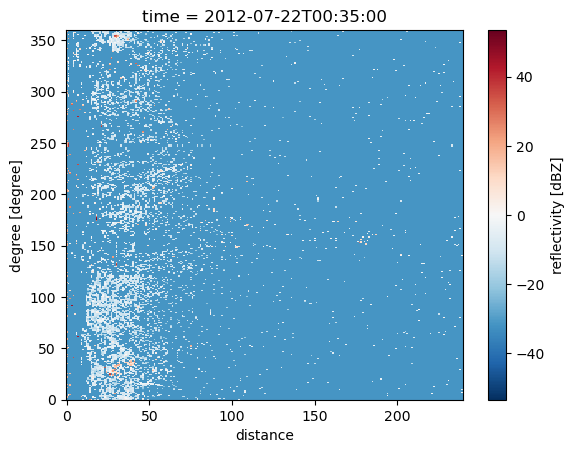

In [146]:
ds.isel(angle=0).reset_coords().squeeze()['reflectivity'].plot()

In [35]:
rm -rf radar.nc

In [37]:
aa = h5py.File(filename, 'r')

In [51]:
aa.keys()

<KeysViewHDF5 ['geographic', 'image1', 'overview', 'radar1', 'scan1', 'scan10', 'scan11', 'scan12', 'scan13', 'scan14', 'scan2', 'scan3', 'scan4', 'scan5', 'scan6', 'scan7', 'scan8', 'scan9', 'visualisation1', 'visualisation2', 'visualisation3']>

In [76]:
import xarray as xr
import xradar as xd

In [83]:
dtree = xr.open_datatree(filename)

In [100]:
ds = dtree['/scan1'].to_dataset()

In [103]:
ds = ds.rename_dims({'phony_dim_0':'azimuth', 'phony_dim_1':'range'})

In [104]:
ds.xradar.georeference()

AttributeError: 'Dataset' object has no attribute 'longitude'